# 6. Some things to try as next research steps

## 6.1. Important Remarks

If you are accessing this tutorial via [Google Colab](https://colab.research.google.com/github/mariusbock/dl-for-har/blob/main/tutorial_notebooks/training.ipynb), first make sure to use Google Colab in English. This will help us to better assist you with issues that might arise during the tutorial. There are two ways to change the default language if it isn't English already:
1. On Google Colab, go to `Help` -> `View in English` 
2. Change the default language of your browser to `English`.

To also ease the communication when communicating errors, enable line numbers within the settings of Colab.

1. On Google Colab, go to `Tools` -> `Settings` -> `Editor` -> `Show line numbers`

In general, we strongly advise you to use Google Colab as it provides you with a working Python distribution as well as free GPU resources. To make Colab use GPUs, you need to change the current notebooks runtime type via:

- `Runtime` -> `Change runtime type` -> `Dropdown` -> `GPU` -> `Save`

**Hint:** you can auto-complete code in Colab via `ctrl` + `spacebar`

For the live tutorial, we require all participants to use Colab. If you decide to rerun the tutorial at later points and rather want to have it run locally on your machine, feel free to clone our [GitHub repository](https://github.com/mariusbock/dl-for-har).

To get started with this notebook, you need to first run the code cell below. Please set `use_colab` to be `True` if you are accessing this notebook via Colab. If not, please set it to `False`. This code cell will make sure that imports from our GitHub repository will work.

In [1]:
import os, sys

use_colab = False

module_path = os.path.abspath(os.path.join('..'))

if use_colab:
    # move to content directory and remove directory for a clean start 
    %cd /content/         
    %rm -rf dl-for-har
    # clone package repository (will throw error if already cloned)
    !git clone https://github.com/mariusbock/dl-for-har.git
    # navigate to dl-for-har directory
    %cd dl-for-har/       
else:
    os.chdir(module_path)
    
# this statement is needed so that we can use the methods of the DL-ARC pipeline
if module_path not in sys.path:
    sys.path.append(module_path)
    
print(module_path)

c:\nishil\Nishil_study\4th sem\RAML\my project HAR\dl-for-har


## 6.2. Loading and preparing the data

Nothing to be adapted here

In [2]:
import numpy as np
import warnings

from data_processing.sliding_window import apply_sliding_window
from data_processing.preprocess_data import load_dataset

warnings.filterwarnings('ignore')


# data loading (we are using a predefined method called load_dataset, which is part of the DL-ARC feature stack)
X, y, num_classes, class_names, sampling_rate, has_null = load_dataset('rwhar_3sbjs', include_null=True)
# since the method returns features and labels separatley, we need to concat them
data = np.concatenate((X, y[:, None]), axis=1)

# define the train data to be all data belonging to the first two subjects
train_data = data[data[:, 0] <= 1]
# define the validation data to be all data belonging to the third subject
valid_data = data[data[:, 0] == 2]

# settings for the sliding window (change them if you want to!)
sw_length = 50
sw_unit = 'units'
sw_overlap = 50

# apply a sliding window on top of both the train and validation data; you can use our predefined method
X_train, y_train = apply_sliding_window(train_data[:, :-1], train_data[:, -1], sliding_window_size=sw_length, unit=sw_unit, sampling_rate=50, sliding_window_overlap=sw_overlap)
X_valid, y_valid = apply_sliding_window(valid_data[:, :-1], valid_data[:, -1], sliding_window_size=sw_length, unit=sw_unit, sampling_rate=50, sliding_window_overlap=sw_overlap)

# (optional) omit the first feature column (subject_identifier) from the train and validation dataset
X_train, X_valid = X_train[:, :, 1:], X_valid[:, :, 1:]

# convert the features of the train and validation to float32 and labels to uint8 for GPU compatibility 
X_train, y_train = X_train.astype(np.float32), y_train.astype(np.uint8)
X_valid, y_valid = X_valid.astype(np.float32), y_valid.astype(np.uint8)

Processing dataset files ...
Full dataset with size: | X (659260, 4) | y (659260,) | 
 ..from file data/rwhar_3sbjs_data.csv


## 6.3. Training with and without Label Smoothing

### 6.3.1. Define the Config Object

Nothing to be done here.

In [3]:
config = {
    #### TRY AND CHANGE THESE PARAMETERS ####
    # sliding window settings
    'sw_length': 50,
    'sw_unit': 'units',
    'sampling_rate': 50,
    'sw_overlap': 30,
    # network settings
    'nb_conv_blocks': 2,
    'conv_block_type': 'normal',
    'nb_filters': 64,
    'filter_width': 11,
    'no_lstm': False,
    'nb_units_lstm': 128,
    'nb_layers_lstm': 1,
    'drop_prob': 0.5,
    # training settings
    'epochs': 30,
    'batch_size': 100,
    'loss': 'cross_entropy',
    'weighted': True,
    'weights_init': 'xavier_uniform',
    'shuffling': True,
    'optimizer': 'adam',
    'lr': 1e-4,
    'weight_decay': 1e-6,
    ### UP FROM HERE YOU SHOULD RATHER NOT CHANGE THESE ####
    'batch_norm': False,
    'dilation': 1,
    'pooling': False,
    'pool_type': 'max',
    'pool_kernel_width': 2,
    'reduce_layer': False,
    'reduce_layer_output': 10,
    'nb_classes': 8,
    'seed': 1,
    'gpu': 'cuda:0',
    'verbose': False,
    'print_freq': 10,
    'valid_epoch': 'last',
    'save_gradient_plot': False,
    'print_counts': False,
    'adj_lr': False,
    'adj_lr_patience': 5,
    'early_stopping': False,
    'es_patience': 5,
    'save_test_preds': False
}


config['window_size'] = X_train.shape[1]
config['nb_channels'] = X_train.shape[2]
config['nb_classes'] = len(class_names)

### 6.3.3. Without Label Smoothing

Nothing to be done here - this has be covered / discussed before.

In [4]:
from misc.torchutils import seed_torch
from model.DeepConvLSTM import DeepConvLSTM
import model.train as training
from datetime import datetime
import torch
seed_torch(config['seed'])

# initialize your DeepConvLSTM object 
crossEntropyNet = DeepConvLSTM(config)
#network.fc.bias = torch.nn.Parameter(torch.zeros_like(network.fc.bias), requires_grad=False)

# initialize the optimizer and loss
optimizer = torch.optim.Adam(crossEntropyNet.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])
criterion = torch.nn.CrossEntropyLoss() # should be the same as LabelSmoothingLoss(0.)



# time and date for logging
now = datetime.now()
todayAsString = now.strftime("%d/%m/%Y")
timeAsString = now.strftime("%H:%M:%S")

crossEntropyNet, crossEntropyNetCheck, trainPredictions, validationPredictions = \
   training.train(X_train, y_train, X_valid, y_valid, crossEntropyNet, optimizer, \
                  criterion, config, todayAsString, timeAsString)

+----------------------------+------------+
|          Modules           | Parameters |
+----------------------------+------------+
| conv_blocks.0.conv1.weight |    704     |
|  conv_blocks.0.conv1.bias  |     64     |
| conv_blocks.0.conv2.weight |   45056    |
|  conv_blocks.0.conv2.bias  |     64     |
| conv_blocks.1.conv1.weight |   45056    |
|  conv_blocks.1.conv1.bias  |     64     |
| conv_blocks.1.conv2.weight |   45056    |
|  conv_blocks.1.conv2.bias  |     64     |
| lstm_layers.0.weight_ih_l0 |   98304    |
| lstm_layers.0.weight_hh_l0 |   65536    |
|  lstm_layers.0.bias_ih_l0  |    512     |
|  lstm_layers.0.bias_hh_l0  |    512     |
|         fc.weight          |    1024    |
|          fc.bias           |     8      |
+----------------------------+------------+
Total Params: 302024
Applied weighted class weights: 
tensor([1.0706, 0.9283, 5.8955, 0.8614, 0.8780, 0.8439, 0.8556, 0.8580])
EPOCH: 1/30 
Train Loss: 1.3588 Train Acc (M): 0.3317 Train Prc (M): 0.4599 Train

### 6.3.4 The Label Smoothing Loss Function

In [5]:
from torch import nn

class LabelSmoothingLoss(nn.Module):
    
    def __init__(self, smoothing=0.0):
        super(LabelSmoothingLoss, self).__init__()
        self.smoothing = smoothing

    def forward(self, prediction, target):
        assert 0 <= self.smoothing < 1
        neglog_softmaxPrediction = -prediction.log_softmax(dim=1)

        with torch.no_grad():
            smoothedLabels = self.smoothing / (prediction.size(1) - 1)* torch.ones_like(prediction)
            smoothedLabels.scatter_(1, target.data.unsqueeze(1), 1-self.smoothing)
        return torch.mean(torch.sum(smoothedLabels * neglog_softmaxPrediction, dim=1)) 

Now implement / try out HAR with different amounts of label smoothing. 

In [7]:
seed_torch(config['seed'])

ls_Net = DeepConvLSTM(config)

# initialize the optimizer and loss
optimizer = torch.optim.Adam(ls_Net.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])
criterion = LabelSmoothingLoss(0.4)

now = datetime.now()
todayAsString = now.strftime("%d/%m/%Y")
timeAsString = now.strftime("%H:%M:%S")

labelSmoothingNet, labelSmoothingNetCheck, trainPredictions, validationPredictions = \
   training.train(X_train, y_train, X_valid, y_valid, ls_Net, optimizer, \
                  criterion, config, todayAsString, timeAsString)

+----------------------------+------------+
|          Modules           | Parameters |
+----------------------------+------------+
| conv_blocks.0.conv1.weight |    704     |
|  conv_blocks.0.conv1.bias  |     64     |
| conv_blocks.0.conv2.weight |   45056    |
|  conv_blocks.0.conv2.bias  |     64     |
| conv_blocks.1.conv1.weight |   45056    |
|  conv_blocks.1.conv1.bias  |     64     |
| conv_blocks.1.conv2.weight |   45056    |
|  conv_blocks.1.conv2.bias  |     64     |
| lstm_layers.0.weight_ih_l0 |   98304    |
| lstm_layers.0.weight_hh_l0 |   65536    |
|  lstm_layers.0.bias_ih_l0  |    512     |
|  lstm_layers.0.bias_hh_l0  |    512     |
|         fc.weight          |    1024    |
|          fc.bias           |     8      |
+----------------------------+------------+
Total Params: 302024
Applied weighted class weights: 
tensor([1.0706, 0.9283, 5.8955, 0.8614, 0.8780, 0.8439, 0.8556, 0.8580])
EPOCH: 1/30 
Train Loss: 1.8386 Train Acc (M): 0.3483 Train Prc (M): 0.5018 Train

## 6.4 Visualization of the networks predictions on three classes

In [8]:
## helper for extracting activations
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [9]:
import matplotlib.pyplot as plt

## Visualization of the activations -- warning: This function expects the penultimate layer's name to be 'fc'
def visualizeActivations(classes, net, inputData, inputDataLabels, penultimateLayerName, lastLayerName):
    ## Extract the 'templates' to which the distances are computed
    features = torch.zeros_like(getattr(net,lastLayerName).weight[0:3,:])
    for i in range(3):
        features[i,:] = -getattr(net,lastLayerName).weight[classes[i],:]

    ## Determine two orthogonal vectors that span the plane containing the three features
    V1 = features[0,:] - features[2,:]
    V1 = V1 / torch.norm(V1)
    V2 = features[1,:] - features[2,:]
    V2 = V2 - (V2.T@V1)*V1
    V2 = V2 / torch.norm(V2)

    net.eval()
    with torch.no_grad():
        ## Now compute the penultimate activations
        handle = getattr(net,penultimateLayerName).register_forward_hook(get_activation('penultimateActivations'))
        for i in range(3):
            output = net(inputData[inputDataLabels==classes[i],:,:])
            coord1 = activation['penultimateActivations']@V1[:,None]
            coord2 = activation['penultimateActivations']@V2[:,None]
            plt.plot(coord1.detach().cpu().numpy(), coord2.detach().cpu().numpy(), 'x')

        handle.remove()

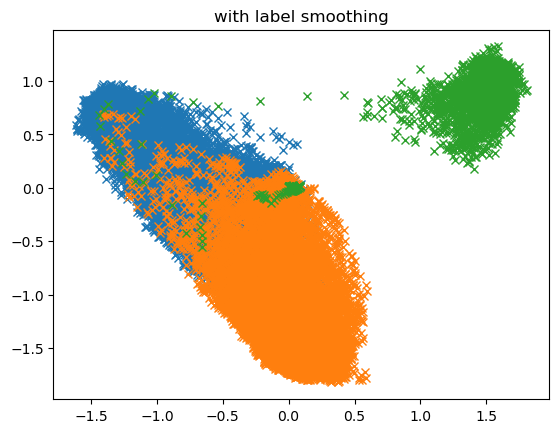

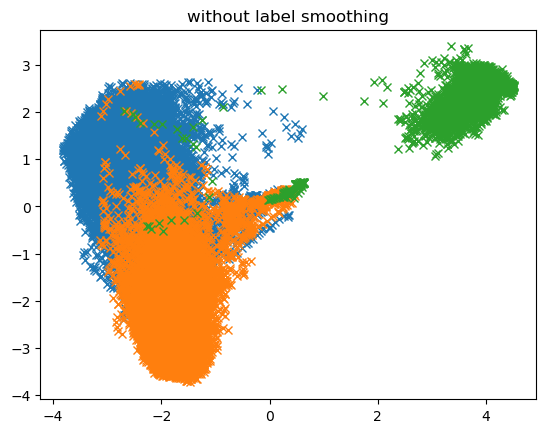

In [10]:
penultimateLayerName = 'dropout'
lastLayerName = 'fc'
classes = [0,1,2]


plt.title('with label smoothing')
visualizeActivations(classes, labelSmoothingNet, torch.from_numpy(X_train).to(config['gpu']),torch.from_numpy(y_train).to(config['gpu']), \
                    penultimateLayerName,lastLayerName)
plt.show()


plt.title('without label smoothing')
visualizeActivations(classes, crossEntropyNet, torch.from_numpy(X_train).to(config['gpu']),torch.from_numpy(y_train).to(config['gpu']), \
                    penultimateLayerName,lastLayerName)
plt.show()

## 6.5 MaxUp Implementation

This section refers to the second part - data augmentation and maxup training

### 6.5.1 MaxUp as a Class

As a suggestion, the Maxup class could consist of two functionalities: A forward pass that gets x and y as an input, and returns additional data as well as additional labels (increasing the amount of data by a factor of 'ntrials' or 'm' in the presentation). The second function is the adapted_loss that knows the structure of the data such that a reshaping is possible in order to have the 'ntrials'-many examples along one dimension, in which a maximum can be computed.    

In [12]:
## Implementation inspired by https://github.com/JonasGeiping/data-poisoning/
# see forest / data / mixing_data_augmentations.py

class Maxup(torch.nn.Module):
    """A meta-augmentation, returning the worst result from a range of augmentations.
    As in the orignal paper, https://arxiv.org/abs/2002.09024,
    """

    def __init__(self, given_data_augmentation, ntrials=4):
        """Initialize with a given data augmentation module."""
        super().__init__()
        self.augment = given_data_augmentation
        self.ntrials = ntrials
        self.max_criterion = torch.nn.CrossEntropyLoss(reduction='none')

    def forward(self, x, y):
        additional_x, additional_labels = [], []
        for trial in range(self.ntrials):
            x_out, y_out = self.augment(x, y)
            additional_x.append(x_out)
            additional_labels.append(y_out)

        additional_x = torch.cat(additional_x, dim=0)
        additional_labels = torch.cat(additional_labels, dim=0)
        
        return additional_x, additional_labels


    def maxup_loss(self, outputs, extra_labels):
        """Compute loss. Here the loss is computed as worst-case estimate over the trials."""
        batch_size = outputs.shape[0] // self.ntrials
        correct_preds = (torch.argmax(outputs.data, dim=1) == extra_labels).sum().item() / self.ntrials
        stacked_loss = self.max_criterion(outputs, extra_labels).view(batch_size, self.ntrials, -1)
        loss = stacked_loss.max(dim=1)[0].mean()
        
        return loss, correct_preds

In [13]:
def myNoiseAdditionAugmenter(x,y):
    #
    # Todo: Write an augmentation that adds noise to x and keeps the label unchanged.
    sigma = 0.3
    x_added_noise = x + sigma*torch.randn_like(x)
    return x_added_noise, y

In [ ]:
#
#
#
# Todo if you like: Possibly write more sophisticated data augmentation methods, e.g. inspired by Mixup, Cutout, or Cutmix.
#
#
#

## 6.5.2 Maxup in the training proceedure 

In [14]:
from model.DeepConvLSTM import DeepConvLSTM
import torch
from torch.utils.data import DataLoader

# initialize your DeepConvLSTM object 
seed_torch(config['seed'])
network = DeepConvLSTM(config)

# sends network to the GPU and sets it to training mode
network.to(config['gpu'])
network.train()

# initialize the optimizer and loss
optimizer = torch.optim.Adam(network.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])
maxup = Maxup(myNoiseAdditionAugmenter, ntrials=4)


# initialize training and validation dataset, define DataLoaders
dataset = torch.utils.data.TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
trainloader = DataLoader(dataset, batch_size=config['batch_size'], shuffle=True)
dataset = torch.utils.data.TensorDataset(torch.from_numpy(X_valid).float(), torch.from_numpy(y_valid))
valloader = DataLoader(dataset, batch_size=config['batch_size'], shuffle=False)


# define your training loop; iterates over the number of epochs
for e in range(config['epochs']):
    counter = 1

    # iterate over the trainloader object (it'll return batches which you can use)
    for i, (x, y) in enumerate(trainloader):
        # sends batch x and y to the GPU
        inputs, targets = x.to(config['gpu']), y.to(config['gpu'])
        
        optimizer.zero_grad()

        # Increase the inputs via data augmentation
        inputs,targets = maxup(inputs,targets)
        
        # send inputs through network to get predictions
        train_output = network(inputs)

        # calculates loss
        loss = maxup.maxup_loss(train_output, targets.long())[0]

        # backprogate your computed loss through the network
        # use the .backward() and .step() function on your loss and optimizer
        loss.backward()
        optimizer.step()

        # prints out every 100 batches information about the current loss and time per batch
        if counter % 80 == 0:
            print('| epoch {:3d} | current minibatch train loss {:5.2f}'.format(e, loss.item()))
        
        counter += 1

| epoch   0 | current minibatch train loss  2.03
| epoch   0 | current minibatch train loss  1.45
| epoch   1 | current minibatch train loss  1.32
| epoch   1 | current minibatch train loss  1.35
| epoch   2 | current minibatch train loss  1.47
| epoch   2 | current minibatch train loss  1.21
| epoch   3 | current minibatch train loss  1.22
| epoch   3 | current minibatch train loss  1.32
| epoch   4 | current minibatch train loss  1.01
| epoch   4 | current minibatch train loss  1.27
| epoch   5 | current minibatch train loss  1.18
| epoch   5 | current minibatch train loss  1.13
| epoch   6 | current minibatch train loss  1.19
| epoch   6 | current minibatch train loss  1.23
| epoch   7 | current minibatch train loss  1.08
| epoch   7 | current minibatch train loss  1.11
| epoch   8 | current minibatch train loss  1.23
| epoch   8 | current minibatch train loss  1.11
| epoch   9 | current minibatch train loss  0.97
| epoch   9 | current minibatch train loss  1.33
| epoch  10 | curren